![Los Angeles skyline](la_skyline.jpg)

Los Angeles, Californie. La Cité des Anges. Tinseltown. La Capitale Mondiale du Divertissement !

Connue pour son climat chaud, ses palmiers, son littoral étendu et Hollywood, ainsi que pour la production de certains des films et chansons les plus emblématiques. Cependant, comme toute ville très peuplée, elle n’est pas toujours glamour et peut connaître un volume important de criminalité. C’est là que vous pouvez intervenir !

Vous avez été sollicité pour aider le Département de Police de Los Angeles (LAPD) en analysant les données criminelles afin d’identifier des schémas de comportement criminel. Ils prévoient d’utiliser vos analyses pour allouer efficacement les ressources afin de lutter contre divers crimes dans différentes zones.

## Les Données

Ils vous ont fourni un seul jeu de données à utiliser. Un résumé et un aperçu sont fournis ci-dessous.

Il s’agit d’une version modifiée des données originales, qui sont disponibles publiquement sur Los Angeles Open Data.

# crimes.csv

| Colonne        | Description                                                                 |
|----------------|-----------------------------------------------------------------------------|
| `'DR_NO'`      | Numéro de dossier des archives : numéro de dossier officiel composé d'une année à 2 chiffres, d'un ID de zone et de 5 chiffres. |
| `'Date Rptd'`  | Date signalée - JJ/MM/AAAA.                                                 |
| `'DATE OCC'`   | Date de l'événement - JJ/MM/AAAA.                                           |
| `'TIME OCC'`   | Heure de l'événement en format militaire 24 heures.                         |
| `'AREA NAME'`  | Les 21 zones géographiques ou divisions de patrouille sont également désignées par un nom faisant référence à un point de repère ou à la communauté environnante qu'elles desservent. Par exemple, la division de la 77e rue est située à l'intersection de South Broadway et de la 77e rue, desservant les quartiers du sud de Los Angeles. |
| `'Crm Cd Desc'`| Indique le crime commis.                                                    |
| `'Vict Age'`   | Âge de la victime en années.                                                |
| `'Vict Sex'`   | Sexe de la victime : `F` : Femme, `M` : Homme, `X` : Inconnu.               |
| `'Vict Descent'`| Ascendance de la victime :<ul><li>`A` - Autre Asiatique</li><li>`B` - Noir</li><li>`C` - Chinois</li><li>`D` - Cambodgien</li><li>`F` - Philippin</li><li>`G` - Guamanien</li><li>`H` - Hispanique/Latino/Mexicain</li><li>`I` - Amérindien/Autochtone d'Alaska</li><li>`J` - Japonais</li><li>`K` - Coréen</li><li>`L` - Laotien</li><li>`O` - Autre</li><li>`P` - Insulaire du Pacifique</li><li>`S` - Samoan</li><li>`U` - Hawaïen</li><li>`V` - Vietnamien</li><li>`W` - Blanc</li><li>`X` - Inconnu</li><li>`Z` - Indien Asiatique</li></ul> |
| `'Weapon Desc'`| Description de l'arme utilisée (le cas échéant).                             |
| `'Status Desc'`| Statut du crime.                                                            |
| `'LOCATION'`   | Adresse de la rue où le crime a eu lieu.                                    |

In [48]:
# Re-run this cell
# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
crimes = pd.read_csv("crimes.csv", parse_dates=["Date Rptd", "DATE OCC"], dtype={"TIME OCC": str})
crimes.head()

,DR_NO,Date Rptd,DATE OCC,TIME OCC,AREA NAME,Crm Cd Desc,Vict Age,Vict Sex,Vict Descent,Weapon Desc,Status Desc,LOCATION
0,220314085,2022-07-22,2020-05-12,1110,Southwest,THEFT OF IDENTITY,27,F,B,NaN,Invest Cont,2500 S SYCAMORE AV
1,222013040,2022-08-06,2020-06-04,1620,Olympic,THEFT OF IDENTITY,60,M,H,NaN,Invest Cont,3300 SAN MARINO ST
2,220614831,2022-08-18,2020-08-17,1200,Hollywood,THEFT OF IDENTITY,28,M,H,NaN,Invest Cont,1900 TRANSIENT
3,231207725,2023-02-27,2020-01-27,0635,77th Street,THEFT OF IDENTITY,37,M,H,NaN,Invest Cont,6200 4TH AV
4,220213256,2022-07-14,2020-07-14,0900,Rampart,THEFT OF IDENTITY,79,M,B,NaN,Invest Cont,1200 W 7TH ST


In [2]:
# ----- Importation des Bibliothèques ----- 
import pandas as pd  
import numpy as np  
import matplotlib.pyplot as plt  
import seaborn as sns

# ----- Chargement des Données ----- 
crimes = pd.read_csv("crimes.csv", parse_dates=["Date Rptd", "DATE OCC"], dtype={"TIME OCC": str})

# ----- Fonction IQR ----- 
def IQR(df, column):
    """Calculer les bornes supérieure et inférieure basées sur l'IQR."""
    seventy_fifth = df[column].quantile(0.75)
    twenty_fifth = df[column].quantile(0.25)
    iqr_value = seventy_fifth - twenty_fifth  
    upper = seventy_fifth + (1.5 * iqr_value)
    lower = twenty_fifth - (1.5 * iqr_value)
    df = df[(df[column] > lower) & (df[column] < upper)]
    return df

# ----- Nettoyage et Conversion de la Colonne des Heures ----- 
crimes['TIME EN H'] = (crimes['TIME OCC'].astype(float) / 100).round(2)

# Vérification et nettoyage des valeurs aberrantes 
crimes = IQR(crimes, 'TIME EN H')

# ----- Nettoyage de la Colonne des Types de Crime ----- 
# Affichage des valeurs uniques pour entraînement  
print(crimes["Crm Cd Desc"].value_counts())


THEFT OF IDENTITY                                     22670
BATTERY - SIMPLE ASSAULT                              19694
BURGLARY FROM VEHICLE                                 13799
ASSAULT WITH DEADLY WEAPON, AGGRAVATED ASSAULT        13215
INTIMATE PARTNER - SIMPLE ASSAULT                     11981
                                                      ...  
BRIBERY                                                   1
GRAND THEFT / INSURANCE FRAUD                             1
DISRUPT SCHOOL                                            1
FIREARMS EMERGENCY PROTECTIVE ORDER (FIREARMS EPO)        1
LYNCHING                                                  1
Name: Crm Cd Desc, Length: 104, dtype: int64


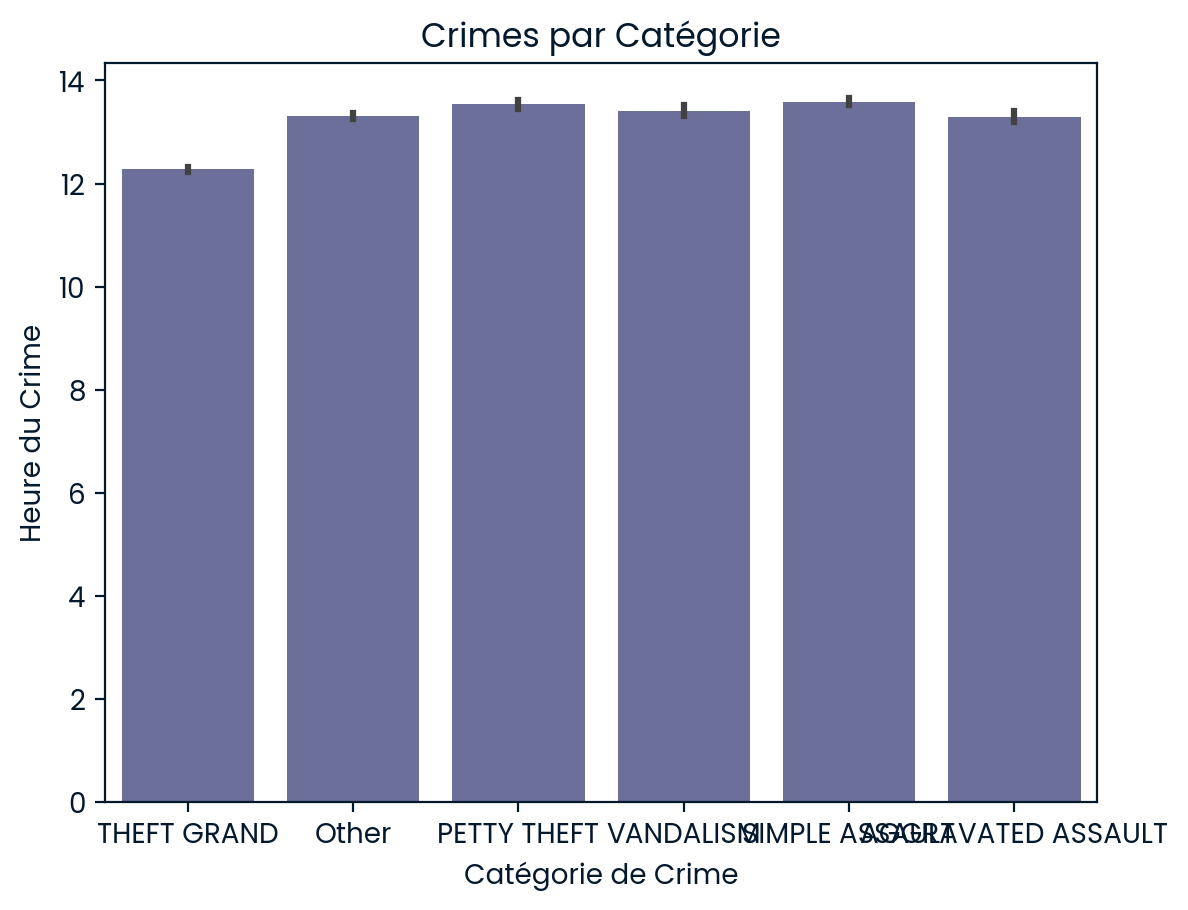

In [3]:
# Définition des catégories de crime  
category_c = ['AGGRAVATED ASSAULT', 'SIMPLE ASSAULT', 'THEFT GRAND', 'PETTY THEFT', 'VANDALISM']
assault_a = "^ASSAULT|AGGRAVATED"
assault_s = "^BATTERY|SIMPLE"
theft_G = "^BURGLARY|^ROBBERY|THEFT FROM MOTOR VEHICLE|THEFT OF IDENTITY"
theft_p = "PETTY"
vandal = "^VANDALISM"

# Conditions pour catégoriser les crimes  
conditions = [
    (crimes["Crm Cd Desc"].str.contains(assault_a)),
    (crimes["Crm Cd Desc"].str.contains(assault_s)),
    (crimes["Crm Cd Desc"].str.contains(theft_G)),
    (crimes["Crm Cd Desc"].str.contains(theft_p)),
    (crimes["Crm Cd Desc"].str.contains(vandal)),
]

# Application des catégories  
crimes['Crimes_category'] = np.select(conditions, category_c, default='Other')

# Regroupement des crimes par catégorie et heure  
crime_f_h = crimes.groupby('Crimes_category')['TIME EN H'].value_counts().reset_index(name='count')

# Visualisation des crimes par catégorie  
sns.barplot(x='Crimes_category', y='TIME EN H', data=crimes)
plt.title('Crimes par Catégorie')
plt.xlabel('Catégorie de Crime')
plt.ylabel('Heure du Crime')
plt.show()

In [5]:
# ----- Analyse des Crimes Nocturnes ----- 
# Filtrage des crimes nocturnes  
bt_10pm_and_00am = (crimes['TIME EN H'] >= 22) & (crimes['TIME EN H'] <= 23.59)
bt_00pm_and_4am = (crimes['TIME EN H'] >= 0) & (crimes['TIME EN H'] <= 3.59)
bt_10pm_and_4am = bt_10pm_and_00am | bt_00pm_and_4am

# Sous-ensemble des crimes nocturnes  
crimes_bt = crimes[bt_10pm_and_4am]

# Regroupement par zone pour les crimes nocturnes  
crimes_f_A = crimes_bt.groupby('AREA NAME')['TIME EN H'].count()
print(crimes_f_A)

# Zone avec le plus de crimes nocturnes (à ajuster selon les résultats)
peak_night_crime_location = 'Central'



AREA NAME
77th Street    2558
Central        3312
Devonshire     1348
Foothill       1260
Harbor         1384
Hollenbeck     1315
Hollywood      2699
Mission        1453
N Hollywood    1855
Newton         2142
Northeast      1684
Olympic        2137
Pacific        1916
Rampart        1860
Southeast      2218
Southwest      2347
Topanga        1461
Van Nuys       1629
West LA        1369
West Valley    1520
Wilshire       1716
Name: TIME EN H, dtype: int64


In [6]:
# ----- Analyse des Âges des Victimes ----- 
# Création des catégories d'âge  
labels = ["0-17", "18-25", "26-34", "35-44", "45-54", "55-64", "65+"]
bins = [0, 17, 25, 34, 44, 54, 64, 100]

# Application de pd.cut pour catégoriser les âges  
crimes['age_categorie'] = pd.cut(crimes['Vict Age'], labels=labels, bins=bins)

# Fréquence des crimes par groupe d'âge  
victim_ages = crimes['age_categorie'].value_counts().sort_index()
print(victim_ages.head())

0-17      4528
18-25    28291
26-34    47470
35-44    42157
45-54    28353
Name: age_categorie, dtype: int64
